## Importación de librerías

In [28]:
# Data processing  
# -----------------------------------------------------------------------  
import numpy as np  
import pandas as pd  

# Other objectives  
# -----------------------------------------------------------------------  
import math  

# Graphics  
# -----------------------------------------------------------------------  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore") 

# Curstom functions 
# ----------------------------------------------------------------------- 
from src.support_eda import plot_categoric_distribution, plot_correlation_matrix, plot_numeric_distribution, plot_relation_tv_numeric, plot_outliers  

## Carga de datos

In [29]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated', 'lastSeen'])

In [30]:
df.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### Selección de columnas

Vamos a eliminar columnas que no nos aporten información relevante:

* `dateCrawled`, `dateCreated`, `lastSeen`: En el EDA preliminar habíamos visto que los anuncios son de entre 2014 y 2016 y que más allá de eso no nos aporta más información.

* `seller`: Todos los valores son `private` salvo 3 entradas, que son `commercial`. Vamos a eliminar directamente la columna.

* `offerType`: De igual forma, todos los valores son `offer` salvo 12 entradas, que son `request`. Podemos eliminar la columna y los vehículos que son `request`.

* `model`: Tenemos más de 250 entradas y es una subcategoría de `brand`. Podríamos dejarla para un análisis más granular pero ahora vamos a eliminarla.

* `monthOfRegistration`: Podríamos hacer un análisis de estacionalidad o por temporadas, pero no será el caso. Además, hay un valor que es 0, lo cual es imposible para meses por lo que realmente sería desconocido. Utilizaremos solamente `yearOfRegistration`.

* `nrOfPictures`: Todos los valores son 0 por lo que no aporta valor.

* `postalCode`: Esta variable corresponde a códigos postales y podría tratarse como categórica. Sin embargo, no nos aporta mucha información que nos resulte útil, por ello decidimos eliminarla.

In [31]:
columnas_eliminar = [
    'dateCrawled',
    'dateCreated', 
    'lastSeen',
    'seller', 
    'offerType', 
    'model', 
    'monthOfRegistration', 
    'nrOfPictures',
    'postalCode'
    ]

In [32]:
df.drop(columns=columnas_eliminar, inplace=True)

## Limpieza de datos

Vayamos columna a columna

In [33]:
df.columns.to_list()

['name',
 'price',
 'vehicleType',
 'yearOfRegistration',
 'gearbox',
 'powerCV',
 'kilometer',
 'fuelType',
 'brand',
 'notRepairedDamage']

### Columna `price`

Valores de precio extremadamente bajos no tienen sentido. Sin embargo, es difícil establecer un criterio estricto para filtrar ya que vehículos muy antiguos o con daños realmente pueden tener precios muy bajos.

In [34]:
print(f"El porcentaje de valores nulos en la columna price es: {df['price'].isna().sum()}")

El porcentaje de valores nulos en la columna price es: 0


Como no teníamos valores nulos, veamos qué proporción de vehículos tienen un valor inferior a cierto umbral. Podemos elegir el umbral por ejemplo en 100 (presumiblemente euros).

In [35]:
umbral_precio_inferior = 100
porcentaje_baratos = (df['price'] < umbral_precio_inferior).mean() * 100

print(f"El porcentaje de vehículos por debajo de {umbral_precio_inferior} es: {porcentaje_baratos:.2f}")

El porcentaje de vehículos por debajo de 100 es: 3.59


Los datos con un precio inferior a 100 son muy probablemente erróneos y representan alrededor del 3,6 % del conjunto de datos, por lo que parece razonable eliminarlos.  

Es posible que haya vehículos que realmente tengan un precio por debajo de 100 debido a daños no reparados o a su antigüedad, pero es difícil establecer este criterio, así que procederemos de esta manera.

Veamos ahora qué sucede con los vehículos con un precio muy elevado. Pongamos el umbral en 4M.

In [36]:
umbral_precio_superior = 4e6
porcentaje_caros = (df['price'] > umbral_precio_superior).mean() * 100

print(f"El porcentaje de vehículos por encima de {umbral_precio_superior} es: {porcentaje_caros:.2f}")

El porcentaje de vehículos por encima de 4000000.0 es: 0.01


Podemos revisar manualmente estos datos para comprobar si tienen sentido:

In [37]:
df[df['price'] > umbral_precio_superior].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
77520,Tausch_gegen_gleichwertiges,99999999,NaN,1999,automatic,221.0,150000,petrol,mercedes_benz,NaN
361451,Hilfe_Hilfe_Hilfe,10010011,NaN,2000,NaN,0.0,150000,NaN,sonstige_autos,NaN
338415,Polo_6n_gti__Zustand_egal_,11111111,NaN,2000,NaN,118.0,125000,petrol,volkswagen,NaN
279937,Mercedes_Benz_CLK_Coupe_280_7G_TRONIC_Sport_Av...,14000500,coupe,2008,automatic,228.0,125000,petrol,mercedes_benz,no
196306,Suche_Motorcross_.!,10000000,NaN,2017,manually,0.0,5000,petrol,volkswagen,NaN


Tras revisar los datos, podemos concluir que todos los precios superiores a 4 millones corresponden a registros erróneos.

Por lo tanto, filtramos los datos por precios de esta forma:

In [38]:
filtro_precio = (df['price'] > umbral_precio_inferior) & (df['price'] < umbral_precio_superior)

df = df[filtro_precio]

### Columna `yearOfRegistration`

Tal y como vimos con las columnas de fechas de los anuncios, los registros no pueden ser de después de 2016. Sin embargo, vamos a comprobar las entradas posteriores a este año

In [39]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head()

yearOfRegistration
2017    9925
2018    3797
2019      15
9999      14
5000      14
Name: count, dtype: int64

Vemos que hay unas cuantas entradas en 2017 y 2018, por lo que vamos a mantenerlas ya que es posible que las columnas de fechas que habíamos eliminado posiblemente fuesen las que estaban mal.

El resto de años son mucho menos frecuentes y la mayoría no tienen sentido por lo que podemos asumir que son errores y eliminarlos o etiquetarlos como nulos.

Veamos ahora qué ocurre con vehículos con fechas de registro muy antiguas. Por ejemplo, establezcamos el umbral en 1930.

In [40]:
umbral_fecha = 1950

df[df['yearOfRegistration'] < umbral_fecha]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    36
1000    23
1937    12
1938     8
1929     7
Name: count, dtype: int64

Vemos que tenemos 36 entradas de 1910, que seguramente sean errores (por la fecha de invención del coche). Veamos la distribución de forma gráfica más detallada.

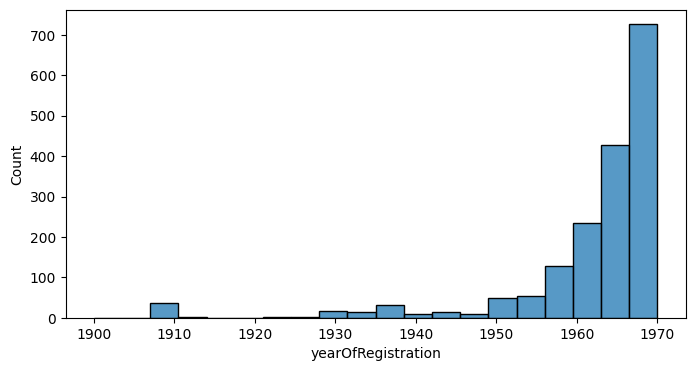

In [41]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(1900, 1970))
plt.show()

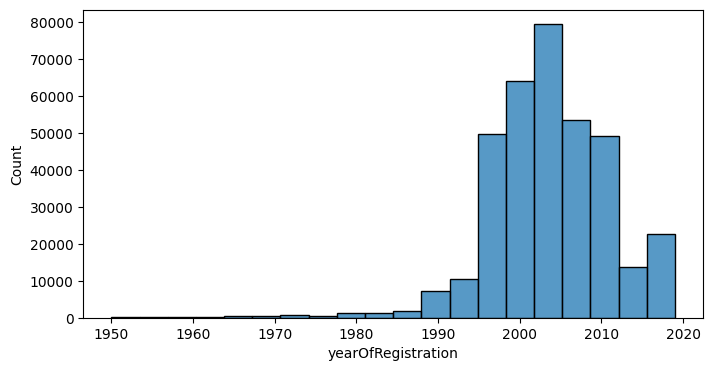

In [42]:
plt.figure(figsize=(8, 4))

sns.histplot(df['yearOfRegistration'], bins=20, binrange=(umbral_fecha, 2019))
plt.show()

Podemos examinar individualmente las entradas de vehículos más antiguos para ver si genuinamente son errores

In [43]:
df[df['yearOfRegistration'] < umbral_fecha].sample(10)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
230289,***Mercedes_W_143__230_Sonnenschein_Limousine***,111111,NaN,1939,manually,57.0,5000,petrol,mercedes_benz,yes
352421,BMW_DIXI_OLDTIMER,20000,coupe,1929,manually,12.0,10000,petrol,bmw,NaN
198973,VW_Kaefer.__Zwei_zum_Preis_von_einem.,1500,NaN,1000,manually,0.0,5000,petrol,volkswagen,NaN
284505,Oldtimer_Opel_Kadett_K38__seltener_4_tuerer__S...,5000,NaN,1938,manually,0.0,5000,petrol,opel,NaN
78584,volkswagen_kuebelwagen_type82_kdf_kuebel_oldti...,12000,suv,1945,manually,44.0,50000,petrol,volkswagen,no
352061,Oldtimer_Aero_30_Roadster_1938,17000,convertible,1944,manually,30.0,5000,petrol,sonstige_autos,no
213933,Golf_Stockcar_/_Auto_Cross_/_Rennen_/_Hobby,222,NaN,1910,manually,0.0,5000,petrol,volkswagen,NaN
228950,Ford_Cabrio,6000,convertible,1932,NaN,0.0,30000,NaN,ford,no
172644,SUCHE_VW_Corrado_Golf2_G60_16V_VR6_Zustand_ega...,99999,NaN,1910,NaN,0.0,150000,NaN,volkswagen,NaN
345248,Tempo_Dreirad_A400_Bj_1945,12000,other,1945,manually,12.0,5000,petrol,sonstige_autos,no


Vemos que la mayoría de estas entradas parecen ser erróneas por lo que directamente vamos a aplicar un filtro para eliminarlas.

También podríamos convertir su año a nulo y luego gestionarlos, pero al tener tan poca información y ser pocas entradas del dataset no nos compensa.

In [44]:
# Nos quedamos con las entradas que sean posteriores a 1950 (el umbral de años que hemos establecido)
df = df[df['yearOfRegistration'] > umbral_fecha]

### Columna `powerCV`

Un vehículo con una potencia de más de 1200 CV prácticamente no existe, y menos aún que se venda de segunda mano. Estos valores serán convertidos a nulos.

Por otra parte, es muy poco frecuente tener vehículos en el rango de entre 550CV y 1200CV, incluso siendo deportivos. Vamos a ver la distribución en este rango.

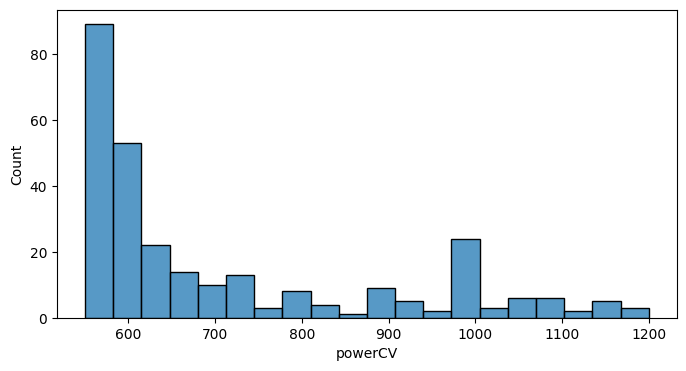

In [45]:
umbral_superior_cv = 550

plt.figure(figsize=(8, 4))

sns.histplot(df['powerCV'], bins=20, binrange=(umbral_superior_cv, 1200))
plt.show()

Veamos cuántas entradas son

In [46]:
df[(df['powerCV'] > umbral_superior_cv)].shape

(518, 10)

Podríamos examinar detenidamente a ver si lo eliminamos o los convertimos a nulos, pero son tan pocas entradas respecto del total que vamos a eliminarlas usando un filtro.

In [47]:
# Nos quedamos con las entradas que tengan una potencia imferior al umbral
df = df[df['powerCV'] < umbral_superior_cv]

En cuanto al rango inferior de potencia, los vehículos con potencia inferior a cierto valor no son realistas. Los vehículos menos potentes del mercado pueden llegar hasta 50CV. Pongamos un umbral de 40CV, para permitir la posibilidad de de que vehículos más antiguos o modestos puedan llegar a niveles más bajos.

Veamos algunas entradas:

In [48]:
df[df['powerCV'] < 40].sample(5)

,name,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage
110549,Passat_2.0_Navi_Leder,2600,combi,2005,NaN,0.0,150000,diesel,volkswagen,NaN
342313,Verkaufe_meinen_sehr_sauberen_Corsa_B_mit_Tuev...,399,small car,1998,manually,0.0,150000,NaN,opel,no
116648,BMW_316_Compact____M_Packet_Sport_,1800,NaN,2005,automatic,0.0,150000,petrol,bmw,NaN
85651,Bmw_528i_Automatik__abn._Ahk_TÜV_neu_top_zustand,3400,NaN,2000,NaN,0.0,150000,petrol,bmw,no
247708,Skoda_fabia_1_2_erste_Hand,1700,NaN,2005,manually,0.0,150000,petrol,skoda,NaN


In [49]:
df[df['powerCV'] < 40].shape[0]

36733

Vemos que hay muchas con un valor de 0 o valores que no tienen sentido. Como son bastantes entradas no las vamos a eliminar sino reemplazarlas por valores nulos

In [50]:
# Generar nulos para estos valores
df['powerCV'] = df['powerCV'].apply(lambda x: np.nan if x < 40 else x)

### Columna `kilometer`

Los km acumulados por un vehículo es una variable numérica continua. Sin embargo, los datos parecen estar agrupados en intervalos discretos.

In [51]:
df['kilometer'].value_counts()

kilometer
150000    230472
125000     37125
100000     15306
90000      12286
80000      10842
70000       9619
60000       8553
50000       7496
40000       6293
30000       5886
20000       5447
5000        5272
10000       1807
Name: count, dtype: int64

In [52]:
df['kilometer'].nunique()

13

Solo tenemos 13 valores diferentes, lo que se ve bien en un histograma.

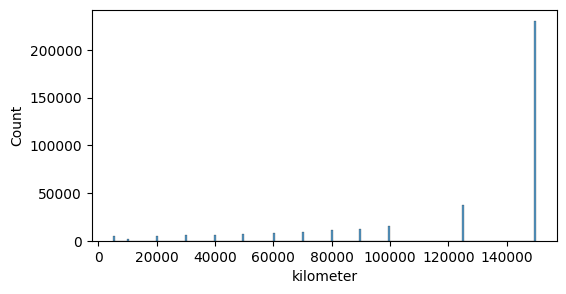

In [57]:
plt.figure(figsize=(6, 3))
sns.histplot(df['kilometer'])
plt.show()

No parece haber ningún valor que sea extraño por lo que vamos a dejarlo como está

### Columna `vehicleType`

In [63]:
df['vehicleType'].value_counts(dropna=False)

vehicleType
NaN            125709
small car       77122
combi           65680
bus             29653
convertible     22436
coupe           18294
suv             14438
other            3072
Name: count, dtype: int64

In [62]:
df['vehicleType'].nunique()

7

Vemos que tenemos 7 tipos de valores diferentes de valores con una gran cantidad de nulos. Podemos directamente crear una nueva categoría que sea `unknown`

In [64]:
df['vehicleType'].fillna('unkonwn', inplace=True)

Podemos visualizarlo en un gráfico de barras

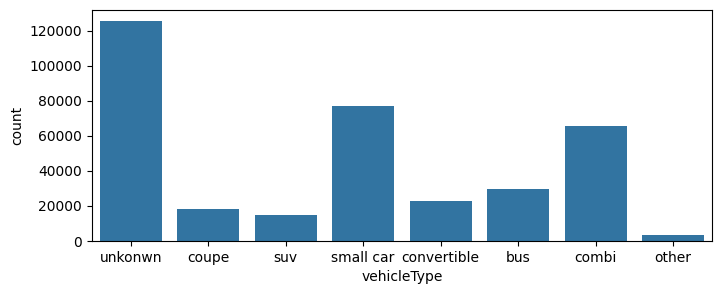

In [ ]:
plt.figure(figsize=(8, 3))
sns.countplot(x=df['vehicleType'])
plt.show()

### Columna `gearbox`

In [69]:
df['gearbox'].value_counts(dropna=False)

gearbox
manually     264840
automatic     75226
NaN           16338
Name: count, dtype: int64

De nuevo, aquí vamos a sustituir los valores nulos por `unknown`

In [70]:
df['gearbox'].fillna('unkonwn', inplace=True)

### Columna `fuelType`

In [72]:
df['fuelType'].unique()

array(['petrol', 'diesel', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electro'], dtype=object)

- ``petrol``: gasolina convencional.  

- ``diesel``: gasoil.  

- ``nan``: dato no disponible.  

- ``lpg``: gas licuado del petróleo, más ecológico y económico.  

- ``other``: otro tipo de combustible no especificado.  

- ``hybrid``: combinación de motor de combustión y eléctrico.  

- ``cng``: gas natural comprimido, alternativa limpia.  

- ``electro``: totalmente eléctrico, sin motor de combustión.

De nuevo, cambiemos los nulos por `unknown`

In [73]:
df['fuelType'].fillna('unkonwn', inplace=True)

In [74]:
df['fuelType'].value_counts()

fuelType
petrol     215947
diesel     105849
unkonwn     28316
lpg          5217
cng           553
hybrid        271
other         154
electro        97
Name: count, dtype: int64

Vemos que casi todos son gasolina o diésel. Unos cuantos son desconocidos y hay una pequeña proporción del resto de categorías.

### Columna `brand`

In [75]:
df['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [76]:
df['brand'].nunique()

40

In [77]:
df['brand'].isna().sum()

np.int64(0)

Tenemos 40 marcas diferentes. Fijémonos en que `sonstige_autos` se traduce como `otros_vehículos`, por lo que podemos modificarlo a `other`, para facilitar la comprensión.

In [81]:
df['brand'] = df['brand'].replace({'sonstige_autos': 'other'})

In [82]:
df['brand'].value_counts()

brand
volkswagen       76203
bmw              38829
opel             38110
mercedes_benz    34368
audi             31746
ford             24378
renault          17154
peugeot          10694
fiat              9223
seat              6759
skoda             5557
mazda             5497
smart             5146
citroen           4973
nissan            4848
toyota            4608
hyundai           3570
mini              3346
volvo             3212
other             3185
mitsubishi        2928
honda             2711
kia               2480
suzuki            2248
alfa_romeo        2230
porsche           2144
chevrolet         1771
chrysler          1356
dacia              887
jeep               776
land_rover         758
daihatsu           753
subaru             734
jaguar             596
daewoo             520
saab               516
trabant            468
rover              455
lancia             455
lada               212
Name: count, dtype: int64